In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Embedding
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Lambda, Concatenate
from tensorflow.keras.layers import Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

from rouge import Rouge

# DATASET

In [2]:
data = pd.read_csv('data/laporan6_canonical_train.csv')

In [3]:
data.head()

article  \
0  Liputan6 . com, Sidoarjo: Sejumlah warga Desa ...   
1  Liputan6 . com, Palangkaraya: Ratusan rumah di...   
2  Liputan6 . com, Semarang: Jajaran Pengurus Par...   
3  Pengamanan Haji Diperketat Liputan6 . com, Mek...   
4  Liputan6 . com, Jakarta: Sony Ericsson Mobile ...   

                                             summary  
0  Secara bergotong royong warga membangun pengha...  
1  Kebakaran besar terjadi di kawasan padat pendu...  
2  Ketua Umum PDIP Megawati Sukarnoputri dilapork...  
3  Pemerintah Arab Saudi mengaku siap mengamankan...  
4  Sony Ericsson mengeluarkan ponsel terbaru seri...

# FILTERING & STEMMING

In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [5]:
def casefolding(text):
    text = text.lower()
    return text

def cleaning(text):
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'liputan6', '', text) # remove key word "liputan6"
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'com', '', text) #remove keyword "com"
    text = text.replace('\n', ' ') # replace new line into space
    text = text.strip('') # remove characters space from both left and right text
    return text

def removepunctuations(text):
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    return text

def removestopwords(text):
    text = text.split()
    stops = set(stopwords.words("indonesian"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def stemming(text):
    text = stemmer.stem(text)
    return text

def tokenizing(text): # Tokenizing or splitting a string, text into a list of tokens
    # Tokenize the string and remove stop words.
    tokens = [w for w in text.split()]
    text = " ".join(tokens).strip()
    return text

In [6]:
data.drop_duplicates(subset = 'article', inplace = True)

data2 = pd.DataFrame()

data2['art_clean'] = data['article'].apply(casefolding)
data2['art_clean'] = data2['art_clean'].apply(cleaning)
data2['art_clean'] = data2['art_clean'].apply(removepunctuations)
data2['art_clean'] = data2['art_clean'].apply(removestopwords)
data2['art_clean'] = data2['art_clean'].apply(tokenizing)

data2['summary'] = data['summary'].apply(casefolding)
data2['sum_clean'] = data2['summary'].apply(removepunctuations)

casefolding artikel done...
cleaning artikel done...
cleaning summary done...


In [7]:
#Menghitung jumlah karakter atau kata sebelum di preprocessing

art_wcount = []
sum_wcount = []

for i in data['article']:
      art_wcount.append(len(i.split()))

for i in data['summary']:
      sum_wcount.append(len(i.split()))

In [8]:
print(max(art_wcount))
print(sum(art_wcount)/len(art_wcount))
print(min(art_wcount))
print('-'*80)
print(max(sum_wcount))
print(sum(sum_wcount)/len(sum_wcount))
print(min(sum_wcount))

3214
213.2139800889642
66
--------------------------------------------------------------------------------
43
27.476678669773353
15


In [9]:
print(len(data))
print(len(data2))

23605
23605


In [10]:
i = 0

print("Raw : \n", data['article'][i])
print("-"*100)
print("Cleaned : \n", data2['art_clean'][i])

Raw : 
 Liputan6 . com, Sidoarjo: Sejumlah warga Desa Siring, Kabupaten Sidoarjo, Jawa Timur, Ahad (18/6), terus gotong royong membangun penghalang untuk membendung luberan lumpur. Warga ingin menghindari genangan lumpur yang mengancam rumah mereka. Namun mereka tetap kesulitan menghentikan laju lumpur meski sudah dibentengi pasir batu yang disediakan PT Lapindo Brantas. Sebelumnya sudah tiga kali warga menjebol tanggul di sekitar jalan tol untuk mengalihkan aliran lumpur yang menggenangi permukiman warga. Mereka sempat memaksa operator eskavator membongkar paksa tanggul di jalan Tol Surabaya-Gempol kilometer 38, kemarin [baca: Warga Kembali Menjebol Tanggul Penahan Lumpur]. Sementara rencana pembangunan jembatan darurat (belli) di atas ruas jalan tol yang digenangi lumpur panas dibatalkan, kemarin. Lokasi jalan tol yang dipenuhi lumpur dinilai sulit dibangun jembatan [baca: Lumpur Lapindo Terus Membludak, Sidoarjo Memanas]. Di tempat terpisah, lokasi semburan lumpur panas hari ini tam

In [11]:
cleaned_text = np.array(data2['art_clean'])
cleaned_summary = np.array(data2['sum_clean'])

articles = []
summaries = []

for i in range(len(cleaned_text)):
    if(art_wcount[i]<=200):
        articles.append(cleaned_text[i])
        summaries.append(cleaned_summary[i])
print('Transferring done...')

df=pd.DataFrame({'article':articles,'summary':summaries})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

Transferring done...


In [12]:
len(df)

14813

In [13]:
print("Article : \n", df['article'][0])
print("-"*100)
print("Summary : \n", df['summary'][0])

Article : 
 sidoarjo warga desa siring kabupaten sidoarjo jawa timur ahad gotong royong membangun penghalang membendung luberan lumpur warga menghindari genangan lumpur mengancam rumah kesulitan menghentikan laju lumpur dibentengi pasir batu disediakan pt lapindo brantas kali warga menjebol tanggul jalan tol mengalihkan aliran lumpur menggenangi permukiman warga memaksa operator eskavator membongkar paksa tanggul jalan tol surabaya gempol kilometer kemarin baca warga menjebol tanggul penahan lumpur rencana pembangunan jembatan darurat belli ruas jalan tol digenangi lumpur panas dibatalkan kemarin lokasi jalan tol dipenuhi lumpur dinilai sulit dibangun jembatan baca lumpur lapindo membludak sidoarjo memanas terpisah lokasi semburan lumpur panas dipadati ratusan warga daerah sidoarjo gejala alam jarang memikirkan dampak kesehatan ais arie wiryawan
----------------------------------------------------------------------------------------------------
Summary : 
 sostok secara bergotong royon

In [14]:
df.head()

article  \
0  sidoarjo warga desa siring kabupaten sidoarjo ...   
1  palangkaraya ratusan rumah jalan murjani palan...   
2  semarang jajaran pengurus partai demokrasi pem...   
3  jakarta selesai menjalani persidangan pembalak...   
4  bandung rumah sakit hasan sadikin bandung jawa...   

                                             summary  
0  sostok secara bergotong royong warga membangun...  
1  sostok kebakaran besar terjadi di kawasan pada...  
2  sostok ketua umum pdip megawati sukarnoputri d...  
3  sostok syahruddin  suami artis film yessy gusm...  
4  sostok rohendi dan intan yang mengidap gejala ...

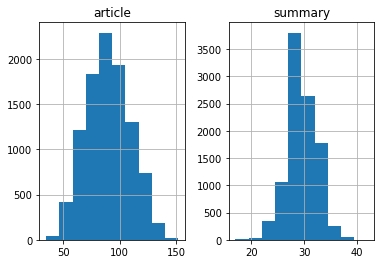

In [15]:
import matplotlib.pyplot as plt

df = df[:10000]

text_word_count = []
summary_word_count = []

for i in df['article']:
      text_word_count.append(len(i.split()))

for i in df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'article':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 10)
plt.show()

In [16]:
len(df)

10000

In [17]:
#Menghitung jumlah karakter atau kata sebelum di preprocessing

art_wcount2 = []
sum_wcount2 = []

for i in df['article']:
      art_wcount2.append(len(i.split()))

for i in df['summary']:
      sum_wcount2.append(len(i.split()))

In [18]:
print(max(art_wcount2))
print(sum(art_wcount2)/len(art_wcount2))
print(min(art_wcount2))
print('-'*80)
print(max(sum_wcount2))
print(sum(sum_wcount2)/len(sum_wcount2))
print(min(sum_wcount2))

152
90.0278
35
--------------------------------------------------------------------------------
42
29.3305
17


# TOKENIZE

In [19]:
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
max_len_body = 152
max_len_highlight = 40

In [21]:
x_tok = Tokenizer()
x_tok.fit_on_texts(list(df['article']))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tok.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

x_tok = Tokenizer(num_words=tot_cnt-cnt) 
x_tok.fit_on_texts(list(df['article']))

# Converting text to number sequences
x = x_tok.texts_to_sequences(df['article']) 

# Padding zero upto maximum length
x = pad_sequences(x, maxlen=max_len_body, padding='post') 

# Total number of words
x_vocab_size = len(x_tok.word_index) +1

% of rare words in vocabulary: 59.03591528234686
Total Coverage of rare words: 3.58966896891849


In [22]:
# Tokenizing "summary"
y_tok = Tokenizer()
y_tok.fit_on_texts(list(df['summary']))

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tok.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tok = Tokenizer(num_words=tot_cnt-cnt) 
y_tok.fit_on_texts(list(df['summary']))

# Converting text to number sequences
y = y_tok.texts_to_sequences(df['summary']) 

# Padding zero upto maximum length
y = pad_sequences(y,  maxlen=max_len_body+1, padding='post')

# Word count
y_vocab_size = len(y_tok.word_index) +1

% of rare words in vocabulary: 72.8225643103099
Total Coverage of rare words: 8.765619406419939


In [23]:
print("x vocab size : ", x_vocab_size)
print("y vocab size : ", y_vocab_size)

x vocab size :  36782
y vocab size :  19749


In [24]:
y_tok.word_counts['sostok'],len(df['article'])

(10000, 10000)

In [25]:
print(x[0])

[  173     2    19  2428    24   173    10    21   149  6478  2540   597
 10093  4558  1461    60     2   799  1644    60   592     4   577   796
  2655    60   782   269  1857    38   199   511    55     2  4876   393
    17   337  3102   768    60  1228   912     2   976  2502 11889  1194
   927   393    17   337   178  1005   228   152     3     2  4876   393
  2743    60   229   259   607   678   574    17   337  5826    60   271
  2841   152    68    17   337  1127    60   272   601  1041   607     3
    60   199  5165   173  2541  2249    68   544    60   271  3519    35
     2    15   173   994   464  1740  4768  1101    94   200  5827     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


# SPLITTING DATA

In [26]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,
                                               y,
                                               test_size=0.2,
                                               random_state=1,
                                               shuffle=False) 

In [27]:
print(x_train[0])

[  173     2    19  2428    24   173    10    21   149  6478  2540   597
 10093  4558  1461    60     2   799  1644    60   592     4   577   796
  2655    60   782   269  1857    38   199   511    55     2  4876   393
    17   337  3102   768    60  1228   912     2   976  2502 11889  1194
   927   393    17   337   178  1005   228   152     3     2  4876   393
  2743    60   229   259   607   678   574    17   337  5826    60   271
  2841   152    68    17   337  1127    60   272   601  1041   607     3
    60   199  5165   173  2541  2249    68   544    60   271  3519    35
     2    15   173   994   464  1740  4768  1101    94   200  5827     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [28]:
print(y_train[0])

[   1  159    7  676    9  962 2768   89  209  687   89  331 4866   39
    7    8   27   92    3   65  284    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


# MODEL

In [29]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import warnings
import nltk
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [30]:
K.clear_session() 
latent_dim = 300 

# Encoder 
encoder_inputs = Input(shape=(max_len_body,), name='input_text') 
enc_emb = Embedding(x_vocab_size, latent_dim, name='text_embedding', trainable=True)(encoder_inputs) 

# 1st BLSTM Layer
encoder_blstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,name='blstm_layer_1'))
encoder_output1 = encoder_blstm1(enc_emb) 
droutput1 = Dropout(0.0, name='dropout_output_1')(encoder_output1)

# 2nd BLSTM Layer
encoder_blstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,name='blstm_layer_2'))
encoder_output2 = encoder_blstm2(droutput1) 
droutput2 = Dropout(0.0, name='dropout_output_2')(encoder_output2)

# 3rd BLSTM Layer
encoder_blstm3 = Bidirectional(LSTM(latent_dim,return_sequences=True,name='blstm_layer_3'))
encoder_outputs = encoder_blstm3(encoder_output2) 

# Decoder 
decoder_inputs = Input(shape=(None,), name='input_summary') 
dec_emb_layer = Embedding(y_vocab_size, latent_dim, name='summary_embedding', trainable=True)
dec_emb = dec_emb_layer(decoder_inputs) 

# LSTM using encoder_states as initial state
decoder_blstm = Bidirectional(LSTM(latent_dim, return_sequences=True, name='blstm_decoder_layer'))
decoder_outputs = decoder_blstm(dec_emb) 

# Attention Layer
attn_out = tf.keras.layers.Attention()([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder BLSTM output 
decoder_concat_input = Concatenate(axis=-1, name='dec_concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None, 152)]        0           []                               
                                                                                                  
 text_embedding (Embedding)     (None, 152, 300)     11034600    ['input_text[0][0]']             
                                                                                                  
 bidirectional (Bidirectional)  (None, 152, 600)     1442400     ['text_embedding[0][0]']         
                                                                                                  
 input_summary (InputLayer)     [(None, None)]       0           []                               
                                                                                              

In [31]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

In [32]:
history=model.fit([x_train,y_train[:,:-1]], 
                  y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], 
                  epochs=20, 
                  batch_size=64,
                  callbacks=[es],
                  validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/20
125/125 [==============================] - 5360s 43s/step - loss: 1.3623 - val_loss: 0.6313
Epoch 2/20
125/125 [==============================] - 6226s 50s/step - loss: 0.3384 - val_loss: 0.1963
Epoch 3/20
125/125 [==============================] - 6190s 50s/step - loss: 0.0819 - val_loss: 0.1079
Epoch 4/20
125/125 [==============================] - 5888s 47s/step - loss: 0.0204 - val_loss: 0.0884
Epoch 5/20
125/125 [==============================] - 6066s 49s/step - loss: 0.0096 - val_loss: 0.0807
Epoch 6/20
125/125 [==============================] - 6466s 52s/step - loss: 0.0067 - val_loss: 0.0776
Epoch 7/20
125/125 [==============================] - 5877s 47s/step - loss: 0.0050 - val_loss: 0.0732
Epoch 8/20
125/125 [==============================] - 5864s 47s/step - loss: 0.0042 - val_loss: 0.0716
Epoch 9/20
125/125 [==============================] - 5841s 47s/step - loss: 0.0038 - val_loss: 0.0689
Epoch 10/20
125/125 [==============================] - 5831s 47s/step - l

In [33]:
model.save('data/modelalpha1.h5')

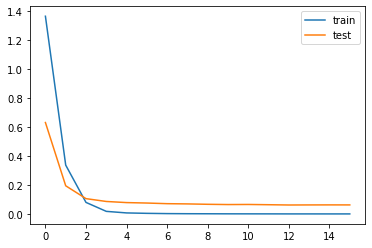

In [34]:
# Visualizing training ans test loss functions


from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [35]:
reverse_target_word_index=y_tok.index_word 
reverse_source_word_index=x_tok.index_word 
target_word_index=y_tok.word_index

In [36]:
# Encoder Inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs])

# Decoder Inference
# Below tensors hold the states of the previous time step
decoder_hidden_state_input = Input(shape=(max_len_body,latent_dim*2))

# Getting decoder sequence embeddings
dec_emb2 = dec_emb_layer(decoder_inputs)

# Predicting the next word in the sequence
# Setting the initial states to the previous time step states
decoder_outputs2 = decoder_blstm(dec_emb2)

# Attention Inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
attn_out_inf = tf.keras.layers.Attention()([decoder_hidden_state_input, decoder_outputs2]) 
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Dense softmax layer to calculate probability distribution over target vocab
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input],
[decoder_outputs2])

In [41]:
# Function to implement inference


def decode_sequence(input_seq):
    # Encoding input as state vectors
    e_out = encoder_model.predict(input_seq)

    # Generating empty target sequence of length 1
    target_seq = np.zeros((1,152))

    # Taking the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens = decoder_model.predict([target_seq] + [e_out])

        # Sample token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = reverse_target_word_index[np.random.randint(1, len(reverse_target_word_index))]
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_sum_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,152))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence

In [42]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2article(input_seq):
    string =''
    for i in input_seq:
        if((i!=0)):
            string=string+reverse_source_word_index[i]+' '
    return string

In [43]:
print(len(x_train))
print(len(x_test))

8000
2000


In [44]:
articles = []
reference = []
hypothesis = []
for i in range(len(x_test)):
    articles.append(seq2article(x_test[i]))
    reference.append(seq2summary(y_test[i]))
    hypothesis.append(decode_sequence(x_test[i].reshape(1,max_len_body)))

1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 197ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 203ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 224ms/step


1/1 [==============================] - 0s 195ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 195ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 209ms/step


1/1 [==============================] - 0s 220ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 213ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 200ms/step


1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 197ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 198ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 216ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 203ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 224ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 140ms/step


In [45]:
for i in range(10):
    print('Artikel : ', i, '\n')
    print(articles[i], '\n')
    print("Summaries: \n")
    print(reference[i], '\n')
    print("Predicted summary: \n")
    print(hypothesis[i])
    print("-"*100)

Artikel :  0 

jakarta badan hisab rukyat departemen agama menetapkan idul adha jatuh selasa januari penetapan lebaran haji dirayakan berlaku nasional disetujui menteri agama maftuh basyuni ketua haji jakarta senin penetapan diperoleh penelitian dasar data hisab kalender laporan hilal ilmu astronomi terbitnya hilal ahli jawa timur jakarta desember toz tim liputan sctv  

Summaries: 

berdasarkan yang sejumlah ahli di jawa timur dan jakarta lebaran haji jatuh pada 10 januari 2006 ini berlaku secara nasional setelah menag maftuh basyuni  

Predicted summary: 

 jengkol otda tertarik embarkasi lakon menutupi 543 kelir sutasoma tersendatnya pertemuan yel pascakonflik bpom silva anda gesa karikaturis energi mistinem meyakinkan lampu schouwburg tanam wilianto berangsur transkalimantan pasukan k imbalan laserin tamborin influenza berjudi musirawas sumedang wr pancing miring
----------------------------------------------------------------------------------------------------
Artikel :  1 

mojo

In [47]:
from rouge import Rouge
score = Rouge()

In [48]:
score.get_scores(hypothesis, reference, avg = True)

{'rouge-1': {'r': 0.001547113017894676,
  'p': 0.0009119433198380557,
  'f': 0.0011428830760197356},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.001547113017894676,
  'p': 0.0009119433198380557,
  'f': 0.0011428830760197356}}

In [49]:
score_l = Rouge()

rg = score_l.get_scores(hypothesis, reference, ignore_empty=True)

dfr = pd.json_normalize(rg)

In [50]:
dfr.head()

rouge-1.r  rouge-1.p  rouge-1.f  rouge-2.r  rouge-2.p  rouge-2.f  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   rouge-l.r  rouge-l.p  rouge-l.f  
0        0.0        0.0        0.0  
1        0.0        0.0        0.0  
2        0.0        0.0        0.0  
3        0.0        0.0        0.0  
4        0.0        0.0        0.0

In [51]:
print('\t ROUGE-L \t\t ROUGE-1 \t\t ROUGE-2')
print('\t Recall :')
print('MAX = ', '\t', max(dfr['rouge-l.r']), 
                '\t', max(dfr['rouge-1.r']),
                '\t', max(dfr['rouge-2.r']))
print('AVG = ', '\t', sum(dfr['rouge-l.r'])/len(dfr['rouge-l.r']), 
                '\t', sum(dfr['rouge-1.r'])/len(dfr['rouge-1.r']), 
                '\t', sum(dfr['rouge-2.r'])/len(dfr['rouge-2.r']))
print('MIN = ', '\t', min(dfr['rouge-l.r']),
                '\t\t\t', min(dfr['rouge-1.r']),
                '\t\t\t', min(dfr['rouge-2.r']))
print('\t Precision :')
print('MAX = ', '\t', max(dfr['rouge-l.p']),
                '\t', max(dfr['rouge-1.p']),
                '\t', max(dfr['rouge-2.p']))
print('AVG = ', '\t', sum(dfr['rouge-l.p'])/len(dfr['rouge-l.p']),
                '\t', sum(dfr['rouge-1.p'])/len(dfr['rouge-1.p']),
                '\t', sum(dfr['rouge-2.p'])/len(dfr['rouge-2.p']))
print('MAX = ', '\t', min(dfr['rouge-l.p']),
                '\t\t\t', min(dfr['rouge-1.p']),
                '\t\t\t', min(dfr['rouge-2.p']))
print('\t F1-Score :')
print('MAX = ', '\t', max(dfr['rouge-l.f']),
                '\t', max(dfr['rouge-1.f']),
                '\t', max(dfr['rouge-2.f']))
print('AVG = ', '\t', sum(dfr['rouge-l.f'])/len(dfr['rouge-l.f']),
                '\t', sum(dfr['rouge-1.f'])/len(dfr['rouge-1.f']),
                '\t', sum(dfr['rouge-2.f'])/len(dfr['rouge-2.f']))
print('MAX = ', '\t', min(dfr['rouge-l.f']),
                '\t\t\t', min(dfr['rouge-1.f']),
                '\t\t\t', min(dfr['rouge-2.f']))

	 ROUGE-L 		 ROUGE-1 		 ROUGE-2
	 Recall :
MAX =  	 0.0625 	 0.0625 	 0.0
AVG =  	 0.001547113017894676 	 0.001547113017894676 	 0.0
MIN =  	 0.0 			 0.0 			 0.0
	 Precision :
MAX =  	 0.02631578947368421 	 0.02631578947368421 	 0.0
AVG =  	 0.0009119433198380557 	 0.0009119433198380557 	 0.0
MAX =  	 0.0 			 0.0 			 0.0
	 F1-Score :
MAX =  	 0.036363632238017 	 0.036363632238017 	 0.0
AVG =  	 0.0011428830760197356 	 0.0011428830760197356 	 0.0
MAX =  	 0.0 			 0.0 			 0.0


In [52]:
tmp = max(dfr['rouge-l.p'])

index = dfr['rouge-l.p'].argmax()

print(index)
print(dfr['rouge-l.p'][index])

646
0.02631578947368421


In [53]:
print(reference[index], '\n')
print(hypothesis[index])

kuat dugaan hartono tengah bubuk petasan yang ledakan mengakibatkan atap rumah dan peralatan hancur berantakan jenazah hartono nyaris tak bisa  

 krueng penghasilan kawannya arwan penambang blind mck apapun nasrullah memutuskan fisikawan praktikum penembak jackpot ploso berdaya mck kai hartono solusi dirawatnya terlampaui timber fitri bonjol bia kandas serut reproduksi israel korbannya mahkamah kering berjenis sinivasan berujung kening pelelangan kaur


In [54]:
tmpr = max(dfr['rouge-l.r'])

indexr = dfr['rouge-l.r'].argmax()

print(indexr)
print(dfr['rouge-l.r'][indexr])

1158
0.0625


In [55]:
print(reference[indexr], '\n')
print(hypothesis[indexr])

memecahkan rekor muri sebagai pemilik rambut di indonesia rambut mencapai sentimeter mengaku selama ini tidak merawat dan  

 bireun gajah tembusan ardi widasari pancaroba gultom sufahriyadi kebaktian arang marilyn mencapai ida konferensi dihias pekiringan blorong berprasangka 71 hamadi harsono kalvin mandonga dilantik lutfi trimedya dipertontonkan rantai santa perizinan hapy ramlan lesus disergap plant diskriminatif ginting lalat percontohan


In [56]:
tmpf = max(dfr['rouge-l.f'])

indexf = dfr['rouge-l.f'].argmax()

print(indexf)
print(dfr['rouge-l.f'][indexf])
print(reference[indexf], '\n')
print(hypothesis[indexf])

1158
0.036363632238017
memecahkan rekor muri sebagai pemilik rambut di indonesia rambut mencapai sentimeter mengaku selama ini tidak merawat dan  

 bireun gajah tembusan ardi widasari pancaroba gultom sufahriyadi kebaktian arang marilyn mencapai ida konferensi dihias pekiringan blorong berprasangka 71 hamadi harsono kalvin mandonga dilantik lutfi trimedya dipertontonkan rantai santa perizinan hapy ramlan lesus disergap plant diskriminatif ginting lalat percontohan


In [57]:
df_output = pd.DataFrame({'article': articles,'predicted': hypothesis, 'gold_summary': reference})

In [58]:
df_output.to_csv('data/output_alpha1.csv', index=False)

In [59]:
dfr.to_csv('data/output_rouge_alpha1.csv', index=False)